# Backpropagation Lab





In [14]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.neural_network import MLPClassifier as MLP2
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split as tts, GridSearchCV as GCV, RandomizedSearchCV as RCV
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import arff
from tqdm import tqdm 
import warnings
warnings.filterwarnings('ignore')

## 1. Correctly implement and submit your own code for the backpropagation algorithm. 

## Code requirements 
- Ability to create a network structure with at least one hidden layer and an arbitrary number of nodes.
- Random weight initialization with small random weights with 0 mean. Remember that every hidden and output node should have its own bias weight.
- Use stochastic training updates: update weights after each training instance (i.e. not batch)
- Implement a validation set based stopping criterion. Keep your *BSSF* and once you go *w* epochs with no improvement (e.g. 10) then use the weights from the *BSSF*.
- Option to include a momentum term

Use your Backpropagation algorithm to solve the Debug data. We provide you with several parameters, and you should be able to replicate our results every time. When you are confident it is correct, run your script on the Evaluation data with the same parameters, and print your final weights.

In [15]:
class MLP(BaseEstimator,ClassifierMixin):

    def __init__(self, hidden_layer_widths=[4], lr=.1, momentum=0, shuffle=True,deterministic=1000,zeros=False):
        self.hidden_layer_widths = hidden_layer_widths
        self.lr = lr
        self.momentum = momentum
        self.shuffle = shuffle
        self.successive_accuracies = [] # VS
        self.successive_mean_squared_errors = [] # VS
        self.training_successive_accuracies = [] # training
        self.training_successive_mean_squared_errors = [] # training
        self.zeros = zeros
        self.deterministic = deterministic
        
        self.sig = lambda x: 1/(1+np.exp(-x))
        self.delta = lambda x: x*(1-x)
        self.error = lambda x,y: (y-x)*(self.delta(x))
        
        if deterministic is not None:
            self.shuffle = False


    def fit(self, X, y, initial_weights=None, split=0.8, epochs = 100, n_iter_no_change=5):
        if self.shuffle:
                X, y = self._shuffle_data(X, y)
        if split < 0 or 1 < split:
            raise ValueError('split should be between 0, and one')
        if split != 1:
            train_num_rows = int(np.rint(X.shape[0] * split))
            train = X[:train_num_rows].copy()
            train_targets = y[:train_num_rows].copy()
            test_X = X[train_num_rows:].copy()
            test_y = y[train_num_rows:].copy()
        else:
            train = X.copy()
            train_targets = y.copy()
            test_X = X.copy()
            test_y = y.copy()

        X = train
        y = train_targets
        #vs for validation set
        self.test_X = test_X
        self.test_y = test_y
        
        self.X_f = X
        self.y_f = y
        m,n = X.shape
        countdown = 0
        
        self.n_classes = len(np.unique(y))
        classes = list(np.unique(y))
        target = np.zeros((m, self.n_classes))
        for i,yy in enumerate(y):
            target[i, classes.index(yy)] = 1
        if self.hidden_layer_widths == None:
            self.hidden_layer_widths = [n*2,self.n_classes+1]
        else:
            self.hidden_layer_widths.append(self.n_classes+1)
        
        self.initial_weights = self.initialize_weights(n) if not initial_weights else initial_weights
        weights = self.initial_weights
        X = np.hstack((X,np.reshape(np.ones_like(X[:,0]),(-1,1))))
        
        prev_delt = [[],[]]
        prev_delt[0] = np.zeros_like(weights[0])
        prev_delt[1] = np.zeros_like(weights[1])
        for i in range(epochs):
            print(f'Fit epoch: {i}', end='\r')
            if countdown >= n_iter_no_change:
                break
            if self.shuffle:
                X, y = self._shuffle_data(X,y)
                
            for j in range(m):
                a = [[],[]]
                delt = [[],[]]
                #forward pass
                for k in range(weights[0].shape[0]):
                    a[0].append(self.sig(np.dot(X[j], weights[0][k])))
                a[0].append(1)
                for k in range(weights[1].shape[0]):
                    a[1].append(self.sig(np.dot(a[0], weights[1][k])))
                #backward pass
                for k in range(target[1].shape[0]):
                    delt[1].append((target[j][k]-a[1][k]) * a[1][k] * (1-a[1][k]))
                for k in range(weights[0].shape[0]+1):
                    delt[0].append(a[0][k]*(1-a[0][k]) * np.dot(weights[1][:,k],delt[1]))
                #update weights
                for k in range(weights[1].shape[0]):
                    weights[1][k] += self.lr * delt[1][k] * np.array(a[0]) + prev_delt[1][k] * self.momentum
                    prev_delt[1][k] = self.lr * delt[1][k] * np.array(a[0]) + prev_delt[1][k] * self.momentum
                for k in range(weights[0].shape[0]):
                    weights[0][k] += self.lr * delt[0][k] * X[j] + prev_delt[0][k] *self.momentum
                    prev_delt[0][k] = self.lr * delt[0][k] * X[j] + prev_delt[0][k] *self.momentum
            self.weights = weights
            self.training_successive_accuracies.append(self.score(X,y, False))
            self.training_successive_mean_squared_errors.append(self.score_mse(X,y, False))
            self.successive_accuracies.append(self.score(test_X,test_y))
            self.successive_mean_squared_errors.append(self.score_mse(test_X,test_y))
            if len(self.training_successive_accuracies) > 2 and self.training_successive_accuracies[-1] <= self.training_successive_accuracies[-2]:
                countdown += 1
            else:
                countdown = 0
                
        print('                                          ', end='\r')
        return self

    def predict(self, X):
        results = []
        for i in range(X.shape[0]):
            a = [[],[]]
            for k in range(self.weights[0].shape[0]):
                a[0].append(self.sig(np.dot(X[i], self.weights[0][k])))
            a[0].append(1)
            for k in range(self.weights[1].shape[0]):
                a[1].append(self.sig(np.dot(a[0], self.weights[1][k])))
            results.append(np.argmax(a[1]))
        return results

    def initialize_weights(self, n):
        weights = []
        s = self.hidden_layer_widths[0]
        weights.append(np.random.normal(0,1,size = (s,n+1)) * (1 - self.zeros))
        weights.append(np.random.normal(0,1,size = (self.n_classes,s+1)) * (1 - self.zeros))
        return weights

    def score_mse(self, X, y, add_bias=True, debug=False):
        if add_bias:   
            X = np.hstack((X,np.reshape(np.ones_like(X[:,0]),(-1,1))))
        prediction = self.predict(X)
        mse = np.mean((y != prediction)**2)
        if debug:
            print(y)
            print(prediction)
            print(mse)
            
        return mse

    def score(self, X, y, add_bias=True):
        if add_bias:   
            X = np.hstack((X,np.reshape(np.ones_like(X[:,0]),(-1,1))))
        prediction = self.predict(X)
        return np.mean(prediction == y)

    def _shuffle_data(self, X, y):
        z = np.column_stack([X,y])
        np.random.shuffle(z)
        new_X = z[:,:-1]
        new_y = z[:,-1]
        return new_X, new_y

    def get_weights(self):
        return self.weights


## 1.1 Debug and Evaluation

Debug your model using the following parameters:

Learning Rate = 0.1\
Momentum = 0.5\
Deterministic = 10 [This means run it 10 epochs and should be the same everytime you run it]\
Shuffle = False\
Validation size = 0\
Initial Weights = All zeros\
Hidden Layer Widths = [4]

---

### 1.1.1 (20%) Debug 

Debug your model by running it on the [Debug Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/linsep2nonorigin.arff)


Expected Results for Binary Classification (i.e. 1 output node): [debug_bp_0.csv](https://github.com/cs472ta/CS472/blob/master/debug_solutions/debug_bp_0.csv) 

$$ \text{Layer 1} = \begin{bmatrix} -8.81779797\text{e}-05 & -8.81779797\text{e}-05 & -8.81779797\text{e}-05 & -8.81779797\text{e}-05 \\ 7.82757731\text{e}-04 & 7.82757731\text{e}-04 & 7.82757731\text{e}-04 & 7.82757731\text{e}-04 \\ -3.94353645\text{e}-03 & -3.94353645\text{e}-03 & -3.94353645\text{e}-03 & -3.94353645\text{e}-03 \end{bmatrix}$$
                                             
$$ \text{Layer 2} = \begin{bmatrix} -0.01060888 \\ -0.01060888 \\ -0.01060888 \\ -0.01060888 \\ -0.02145495 \end{bmatrix}$$


Expected Results for One Hot Vector Classification (i.e. 2 output nodes): [debug_bp_2outs.csv](https://github.com/cs472ta/CS472/blob/master/debug_solutions/debug_bp_2outs.csv) 

$$ \text{Layer 1} = \begin{bmatrix} -0.00018149 & -0.00018149 & -0.00018149 & -0.00018149 \\ 0.00157468 & 0.00157468 & 0.00157468 & 0.00157468 \\ -0.00788218 & -0.00788218 & -0.00788218 & -0.00788218 \end{bmatrix}$$
                          
$$ \text{Layer 2} = \begin{bmatrix} 0.01050642 & -0.01050642 \\ 0.01050642 & -0.01050642 \\ 0.01050642 & -0.01050642 \\ 0.01050642 & -0.01050642 \\ 0.02148778 & -0.02148778 \end{bmatrix}$$

Based on how you index your weights, they may not be in the exact order or shape as our two examples above, but the weight values should be the same.

In [16]:
data = pd.DataFrame(arff.loadarff('linsep2nonorigin.arff')[0], dtype=float)
x = data.drop(columns='class').values
y = data['class'].values
mlp = MLP(hidden_layer_widths=[4], shuffle=False, momentum=.5, lr=.1, zeros=True)
mlp.fit(x,y, epochs=10)
w1,w2 = mlp.get_weights()
print('layer_1:\n',w1)
print('layer_2:\n',w2)

layer_1:
 [[-0.00366968  0.01153121  0.00310188]
 [-0.00366968  0.01153121  0.00310188]
 [-0.00366968  0.01153121  0.00310188]
 [-0.00366968  0.01153121  0.00310188]]
layer_2:
 [[-0.10989669 -0.10989669 -0.10989669 -0.10989669 -0.21913305]
 [ 0.10989669  0.10989669  0.10989669  0.10989669  0.21913305]]


They did not seem to be exactly the same. Layer 1 is off by .030 and the second layer, seems to be off by .104.

### 1.1.2 (20%) Evaluation

Evaluate your model using the SAME parameters as above for the Debug data set

We will evaluate your model based on the weights your code prints after training on the [Evaluation Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/data_banknote_authentication.arff)

In [17]:
data = pd.DataFrame(arff.loadarff('data_banknote_authentication.arff')[0], dtype=float)
x = data.drop(columns=['class']).values
y = data['class'].values
# Train on debug data
mlp = MLP(shuffle=False)
mlp.fit(x,y)
y1, y2 = mlp.get_weights()
print('layer_1:\n',y1)
print('layer_2:\n',y2)
# Check score
print('score\n', mlp.score_mse(x,y))

layer_1:
 [[ 1.27944406  0.61295415  0.7446186   0.07849274 -1.58879902]
 [ 1.75979879  1.30378992  1.57693698  0.02956013 -2.68363266]
 [-0.82684121  1.50045257  1.76997547 -0.03138928 -0.12837724]
 [-2.46839876 -1.17569795 -1.10147378 -0.27241107 -0.44679269]]
layer_2:
 [[ 0.82001458  3.75519752  0.17071574 -3.35124985 -1.63363524]
 [-1.6356516  -3.49349391 -0.55158662  2.84476532  2.25643195]]
score
 0.008017492711370262


*Discussion*

## 2. (10%) Backpropagation on the Iris Classification problem.

Train on the [Iris Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/iris.arff). For this and all following experiments, always start with random weights and shuffle the training set before each epoch. You may use your own data shuffling code and random train/test split code or use scikit-learn versions if you prefer.

Parameters:
- One layer of hidden nodes with the number of hidden nodes being twice the number of inputs.
- Use a random 80/20 split of the data for the training/test set.
- Use a learning rate of 0.1
- Use a validation set (10-15% of the training set is common) taken from the training set for your stopping criteria. 
- Create one graph with MSE (mean squared error, *y*-axis) vs epochs (*x*-axis) for the MSEs on the training set, validation set, and test set. Always include the values at epoch 0 (your initial weights before training)
- Create one graph with classification accuracy (% classified correctly) vs epochs from the training set, validation set, and test set

The results for the different measurables should be shown with a different color, line type, etc. Typical backpropagation accuracies for the Iris data set are 85-95%.

---

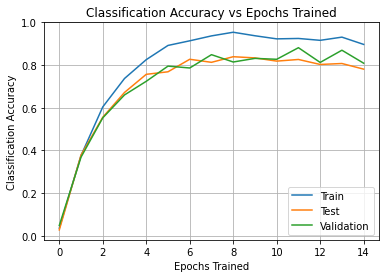

In [18]:
# Sample Graph
import matplotlib.pyplot as plt
import numpy as np

# Use the accuracies/MSEs from your own mlp
train_data = 2.5*np.log(np.linspace(1,3.5,15))/(np.linspace(1,3.5,15))+1/20*np.random.random(15)
test_data = 2.2*np.log(np.linspace(1,3.9,15))/(np.linspace(1,3.9,15))+1/25*np.random.random(15)
val_data = 2.9*np.log(np.linspace(1,3,15))/(np.linspace(1,4,15))+1/15*np.random.random(15)

plt.plot(train_data, label="Train")
plt.plot(test_data, label='Test')
plt.plot(val_data, label='Validation')
plt.legend(loc="lower right")
plt.xlabel('Epochs Trained')
plt.ylabel('Classification Accuracy')
plt.title("Classification Accuracy vs Epochs Trained")
plt.grid()
plt.show()


score
 96.66666666666667 %


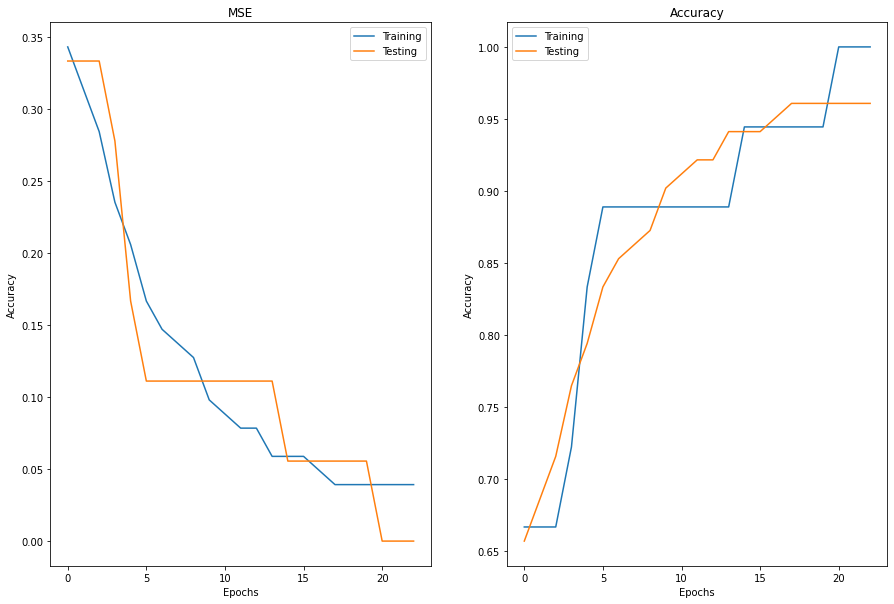

In [19]:
iris = load_iris()
X = iris['data']
print()
y = iris['target']
X_train, X_test, y_train, y_test = tts(X, y, test_size=0.20, random_state=42)
mlp = MLP(lr=.1, hidden_layer_widths=[X.shape[1]*2])
mlp.fit(X_train, y_train, split=.85)
print('score\n',mlp.score(X_test, y_test)*100, '%')
MSE_vals_train = mlp.training_successive_mean_squared_errors
MSE_vals_test = mlp.successive_mean_squared_errors
acc_train = mlp.successive_accuracies
acc_test = mlp.training_successive_accuracies

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10))
                               
ax1.plot(MSE_vals_train, label='Training')
ax1.plot(MSE_vals_test, label='Testing')
ax2.plot(acc_train, label='Training')
ax2.plot(acc_test, label='Testing')
ax1.legend()
ax1.set_title('MSE')
ax2.set_title("Accuracy")
ax1.set_ylabel('Accuracy')
ax1.set_xlabel("Epochs")
ax2.set_ylabel('Accuracy')
ax2.set_xlabel("Epochs")
ax2.legend()
plt.show()

I got a score of 96.66% which is higher for typical backpropagation accuracies for the Iris data set. It is about 1.6% higher than it should be.

## 3. Working with Hyperparameters 
### 3.1 (5%) Vowel Dataset - Intuition
- In this section we use the vowel dataset to consider the hyperparameters of learning rate, number of hidden nodes, and momentum.
- Discuss why the vowel data set has lower accuracy than Iris.
- Report both dataset's baseline accuracies. Baseline accuracy is what you would get if the model just outputs the majority class of the data set.
- Consider which of the vowel datasets given input features you should actually use (Train/test, speaker, gender, etc.) and discuss why you chose the ones you did.

Typical backpropagation accuracies for the Vowel data set are above 75%.

The best learning rates are the ones that are usually between quick and slow moving rates, Because it allows the machine to learn fast enough to get a low error.

### 3.2 (10%) Learning Rate
Load the [Vowel Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/vowel.arff)

- Use one layer of hidden nodes with the number of hidden nodes being twice the number of inputs.
- Use random 75/25 splits of the data for the training/test set.
- Use a validation set taken from the training set for your stopping criteria.
- Try some different learning rates (LR). Note that each LR will require a different number of epochs to learn. 
- These hyperparamaters can effect both accuracy and time required for learning. For each LR you test, plot their validations set's MSE (*y*-axis) vs epochs (*x*-axis). Graph 4-5 different LRs and make them different enough to see a difference between them. For stopping use a window of 5 epochs since no change from *BSSF*. 5 is smaller than typical but fine for demonstrating and viewing the concept here. Show the values for the 5 epochs past *BSSF* but put a point at the *BSSF* epoch to make it clear which model you actually choose for each learning rate. Below is an example graph with made up data. We include the Matplotlib code which you may use as a template, but you may use any graphing tools you want.
- Create a table which includes a row for the final chosen model for each LR, showing the LR, # epochs to learn the model, and the final MSE for the training set, validation set, and test set.


In real testing one averages the results of multiple trials per LR with different intitial conditions. That gives more accurate results but is not required for your report.


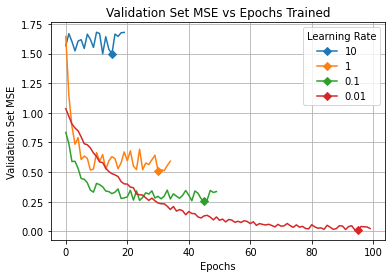

In [20]:
# Sample Graph Code
import matplotlib.pyplot as plt
import numpy as np

# Fake Data 
def mlp(i, lr):
  x1 = np.exp(-.001*np.linspace(0,20,20))+1/5*np.random.random(20)+.5
  x2 = np.exp(-.5*np.linspace(0,35,35))+1/5*np.random.random(35)+.5
  x3 = .5*np.exp(-.2*np.linspace(0,50,50))+1/10*np.random.random(50)+.25
  x4 = np.exp(-.05*np.linspace(0,100,100))+1/25*np.random.random(100)
  data = [x1, x2, x3, x4]
  for x in data: x[-5] = np.amin(x)-.001
  return data[i]

# Graph code
lrs=[10, 1, .1, .01] # Choose some good learning rates
# Some learning rates may go on for many epochs, you can stop them early 
for i, lr in enumerate(lrs):
  mse = mlp(i, lr) # get the MSEs from your own perceptron
  plt.plot(mse, '-D', markevery=[np.argmin(mse)], label=lr)
plt.legend(title="Learning Rate", loc="upper right")
plt.xlabel('Epochs')
plt.ylabel('Validation Set MSE')
plt.title("Validation Set MSE vs Epochs Trained")
plt.grid()
plt.show()

  0%|          | 0/7 [00:00<?, ?it/s]

 14%|█▍        | 1/7 [01:22<08:12, 82.16s/it]

 29%|██▊       | 2/7 [02:41<06:42, 80.43s/it]

 43%|████▎     | 3/7 [03:46<04:53, 73.40s/it]

 57%|█████▋    | 4/7 [04:37<03:13, 64.46s/it]

 71%|███████▏  | 5/7 [05:54<02:18, 69.21s/it]

 86%|████████▌ | 6/7 [07:13<01:12, 72.34s/it]

100%|██████████| 7/7 [08:31<00:00, 73.09s/it]

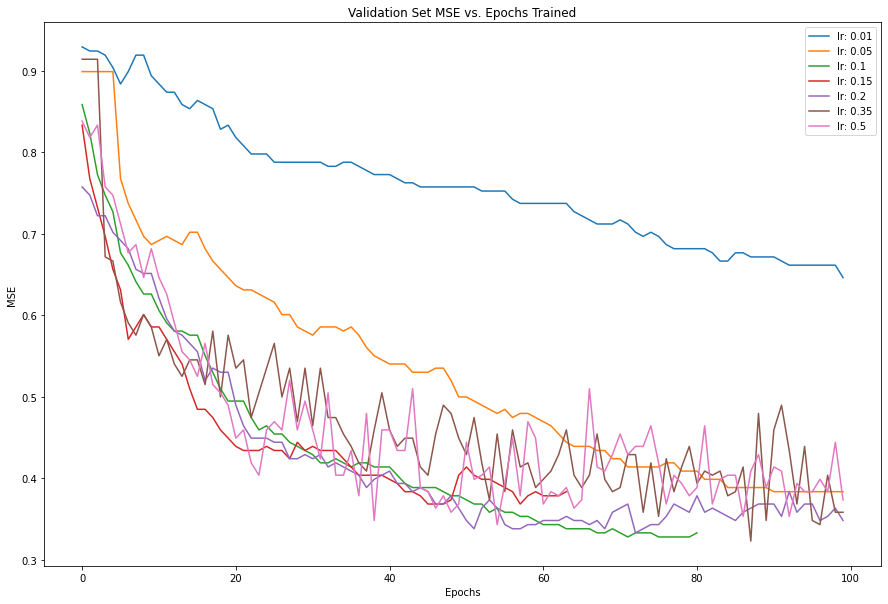

Best Learning Rate: 0.2


In [21]:
data = pd.DataFrame(arff.loadarff('vowel.arff')[0], dtype=float)
mapper = {}
for c in ['Train or Test', 'Speaker Number','Sex','Class']:
    classes = data[c].unique()
    for i,k in enumerate(classes):
        mapper[k] = i
data = data.replace(mapper)
data = data.drop(columns=['Train or Test'])
X = data.drop(columns='Class').values
y = data['Class'].values

X_train, X_test, y_train, y_test = tts(X, y, test_size=0.20, random_state=42)


LRs = [.01, .05, .1, .15, .2, .35, .5]
MSE_test, best_lr_scores = [], []
fig = plt.figure(figsize=(15,10))
for lr in tqdm(LRs):
    mlp = MLP(lr=lr, hidden_layer_widths=[X.shape[1]*2])
    mlp.fit(X_train, y_train, split=.75)
    acc_test = mlp.successive_mean_squared_errors
    best_lr_scores.append(np.mean(acc_test))
    plt.plot(acc_test, label=f'lr: {lr}')
plt.title("Validation Set MSE vs. Epochs Trained")
plt.ylabel('MSE')
plt.xlabel("Epochs")
plt.legend()
plt.show()

print(f'Best Learning Rate: {LRs[np.argmin(best_lr_scores)]}')

In [22]:
print(f'Best Learning Rate: {LRs[np.argmin(best_lr_scores)]}')

Best Learning Rate: 0.2


It seems like the best learning rate is .2 which is about the same as what I said earlier The best learning rates are the ones that are usually between quick and slow moving rates, Because it allows the machine to learn fast enough to get a low error. It seems that this is the case because there is less error compared to the higher weights and takes a reasonable amount of time.

### 3.3 (10%) Number of Hidden Nodes

Using the best LR you discovered, experiment with different numbers of hidden nodes.

- Start with 1 hidden node, then 2, and then double them for each test until you get no more improvement in accuracy. 
- For each number of hidden nodes find the best validation set solution (in terms of validation set MSE).  
- Create both a graph and table just like above, except with # of hidden nodes rather than LR.

In general, whenever you are testing a parameter such # of hidden nodes, test values until no more improvement is found. For example, if 20 hidden nodes did better than 10, you would not stop at 20, but would try 40, etc., until you no longer get improvement.

7.58% Accuracy for 1 Hidden Nodes
31.31% Accuracy for 2 Hidden Nodes
20.20% Accuracy for 4 Hidden Nodes
34.34% Accuracy for 8 Hidden Nodes
49.49% Accuracy for 16 Hidden Nodes
58.59% Accuracy for 32 Hidden Nodes
68.69% Accuracy for 64 Hidden Nodes
43.94% Accuracy for 128 Hidden Nodes
34.34% Accuracy for 256 Hidden Nodes
Best Number of Hidden Nodes was 64


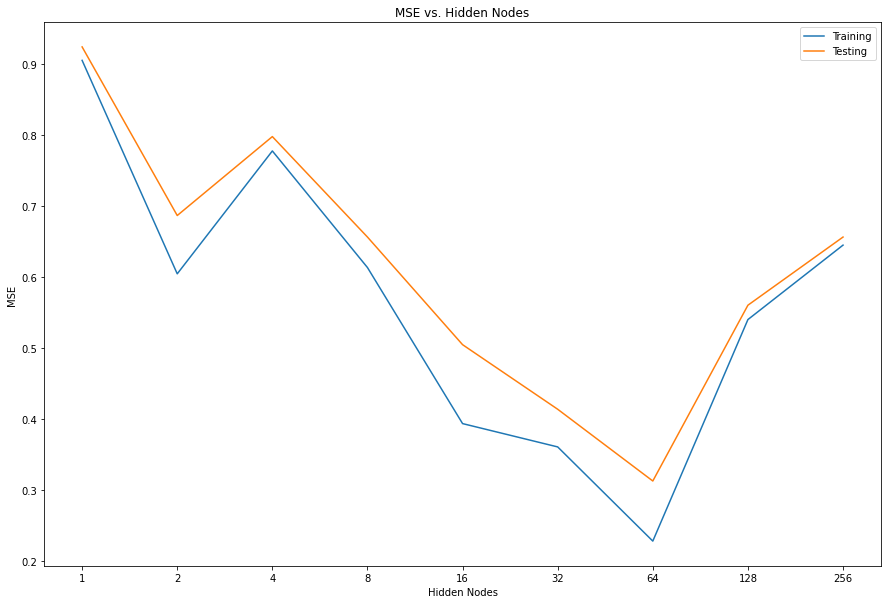

In [23]:
lr = LRs[np.argmin(best_lr_scores)]
train_MSE, test_MSE = [], []
acc_ls = []
Hidden_nodes = []
Hidden_nodes_str = []
count = 0 
for i in range(10):
    if count > 2:
        break
    mlp = MLP(lr=lr, hidden_layer_widths=[2**i])
    mlp.fit(X_train, y_train, epochs=50)
    train_MSE.append(mlp.score_mse(X_train, y_train))
    test_MSE.append(mlp.score_mse(X_test, y_test))
    acc_ls.append(mlp.score(X_test, y_test))
    Hidden_nodes_str.append(str(2**i))
    Hidden_nodes.append(2**i)
    print(f"{acc_ls[-1]*100:.2f}% Accuracy for {2**i} Hidden Nodes")
    if len(acc_ls) > 1 and acc_ls[-1] < acc_ls[-2]:
        count += 1

print(f"Best Number of Hidden Nodes was {Hidden_nodes[np.argmax(acc_ls)]}")
    
fig = plt.figure(figsize=(15,10))
plt.plot(train_MSE, label='Training')
plt.plot(test_MSE, label='Testing')
plt.xticks(range(len(train_MSE)), Hidden_nodes_str)
plt.title(f"MSE vs. Hidden Nodes")
plt.ylabel('MSE')
plt.xlabel("Hidden Nodes")
plt.legend()
plt.show()

From the data collected, it appears that for the hidden nodes i was able to get a 68.69% accuracy from that. I tested once more after to see if there was imporvement, but from the data above, there was no improvement with 128, and 256 Nodes. Therefore, 64 is the best number of hidden nodes.

### 3.4 (10%) Momentum

Try some different momentum terms between 0 and 1 using the best number of hidden nodes and LR from your earlier experiments.

- Create both a graph and table just like above, except with different momentum values rather than LR.

52.02% Accuracy for a Momentum of 0.001
57.07% Accuracy for a Momentum of 0.005
66.16% Accuracy for a Momentum of 0.025
61.11% Accuracy for a Momentum of 0.125
48.48% Accuracy for a Momentum of 0.625
Best Momentum was 0.025


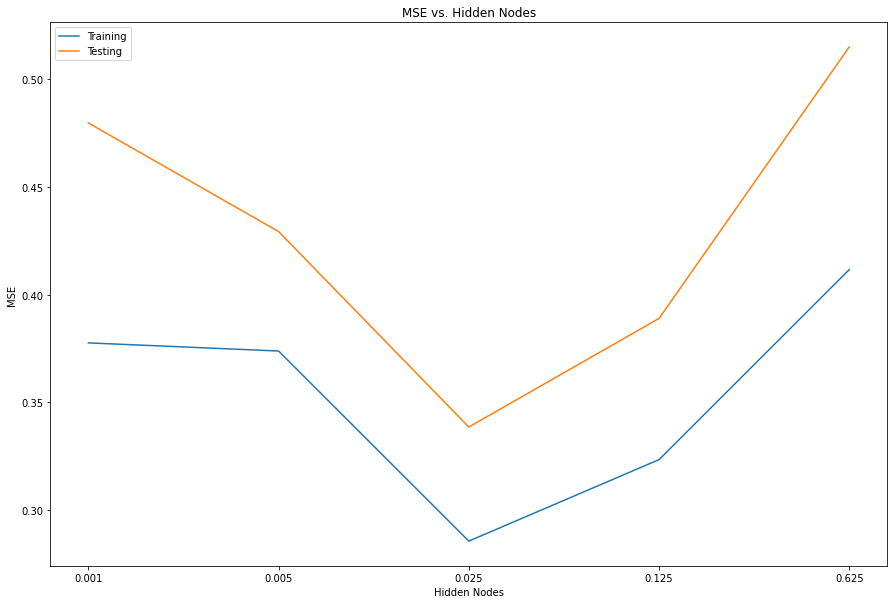

In [24]:
train_score, test_score = [], []
nodes = [64]
i = 0.001
count = 0
train_MSE = []
test_MSE = []
acc_ls = []
momentum_ls = []
while count != 2:
    mlp = MLP(lr=lr, hidden_layer_widths=nodes, momentum=i)
    mlp.fit(X_train, y_train, epochs = 50)
    train_MSE.append(mlp.score_mse(X_train, y_train))
    test_MSE.append(mlp.score_mse(X_test, y_test))
    acc_ls.append(mlp.score(X_test, y_test))
    momentum_ls.append(i)
    print(f"{acc_ls[-1]*100:.2f}% Accuracy for a Momentum of {i}")
    i += i*4
    if len(acc_ls) > 1 and acc_ls[-1] < acc_ls[-2]:
        count += 1

print(f"Best Momentum was {momentum_ls[np.argmax(acc_ls)]}")
    
fig = plt.figure(figsize=(15,10))
plt.plot(train_MSE, label='Training')
plt.plot(test_MSE, label='Testing')
plt.xticks(range(len(train_MSE)), momentum_ls)
plt.title(f"MSE vs. Hidden Nodes")
plt.ylabel('MSE')
plt.xlabel("Hidden Nodes")
plt.legend()
plt.show()

It appears that the lower the momentum that I used from the best amount of nodes from the previous cell, was better than using a higher momentum. From the results that are shown, a mementum of .025 had an accuracy of 66.16% compared to a higher momentum like .125 which had an accuracy of 61.11%

## 4. Scikit-learn Classifier and Comparison

### 4.1 (10%) Use the scikit-learn (SK) version of the MLP classifier on the Iris data set and one data set of your choice.  

You do not need to go through all the steps above, nor graph results. Compare results (accuracy and learning speed) between your version and theirs for some selection of hyper-parameters. Try some different hyper-parameters and comment on their effect.

At a minimum, try

- number of hidden nodes and layers
- different activation functions
- learning rate
- regularization and parameters
- momentum (and try nesterov)
- early stopping

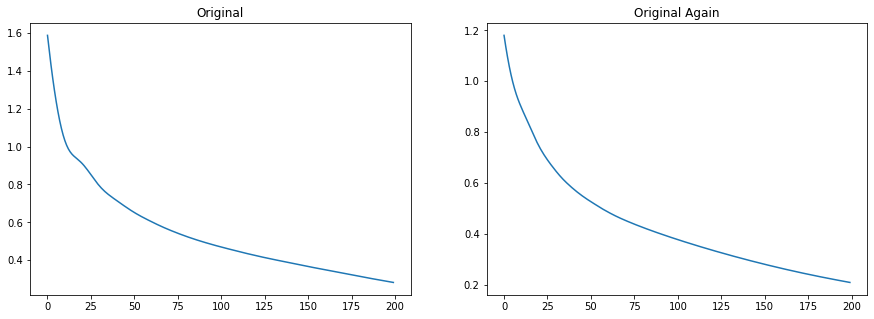

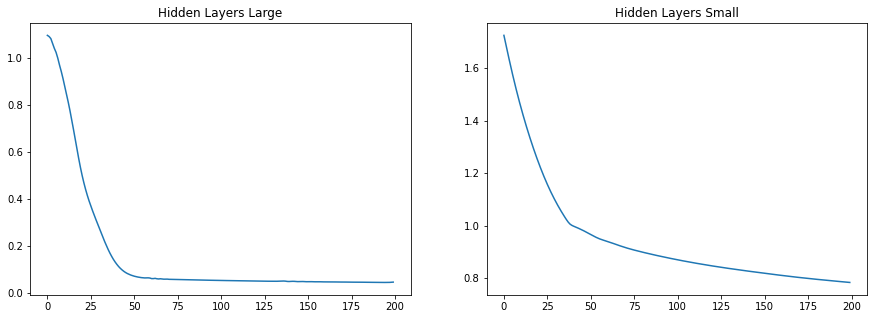

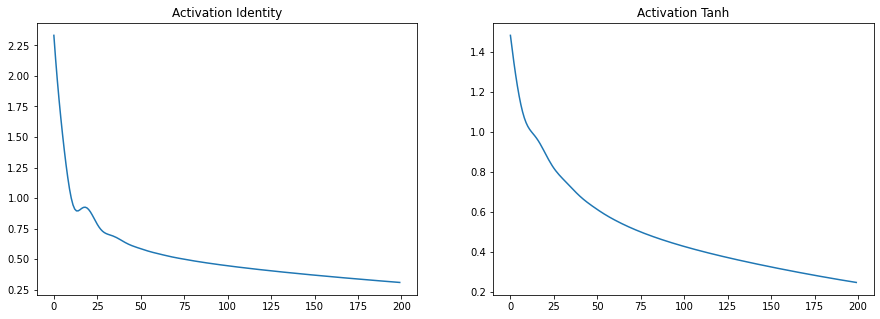

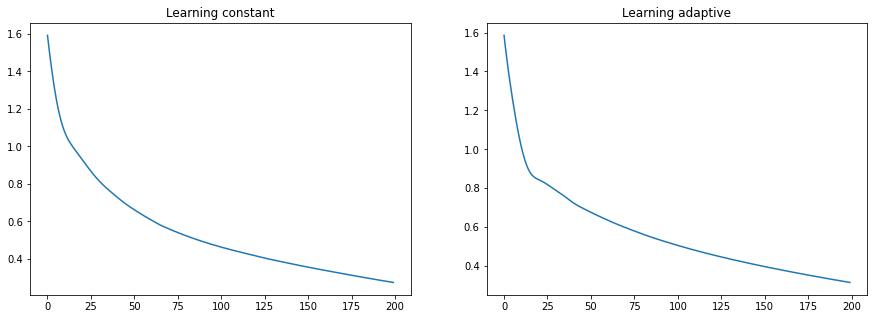

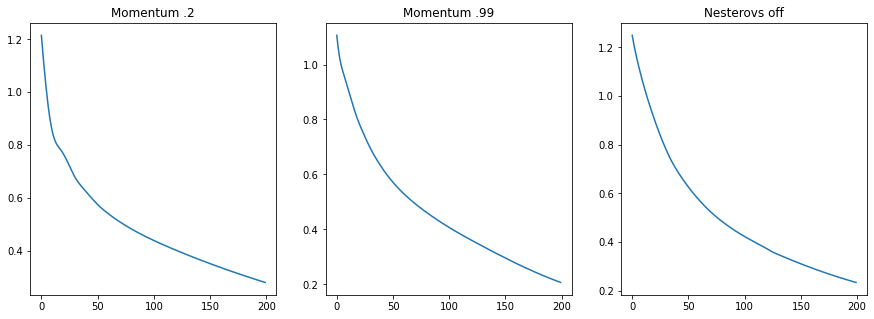

In [25]:
iris = load_iris()
X = iris['data']
y = iris['target']
models = [[MLP2(), MLP2()],
          [MLP2(hidden_layer_sizes=[200,300,10,400]), MLP2(hidden_layer_sizes=[10,20,10,3])],
          [MLP2(activation='identity'), MLP2(activation='tanh')],
          [MLP2(learning_rate='constant'), MLP2(learning_rate='adaptive')],
          [MLP2(momentum=.2), MLP2(momentum=.99), MLP2(nesterovs_momentum=False)]]
titles = [['Original', 'Original Again'],
          ['Hidden Layers Large', 'Hidden Layers Small'],
          ['Activation Identity','Activation Tanh'],
          ['Learning constant','Learning adaptive'],
          ['Momentum .2','Momentum .99','Nesterovs off']]

for model,title in zip(models, titles):
    fig, axes = plt.subplots(1,len(model), figsize=(15,5))
    axes = axes.flatten()
    for m,t,ax in zip(model, title, axes):
        m.fit(X,y)
        ax.plot(m.loss_curve_)
        ax.set_title(t)
    plt.show()

I beleive that it is definetly simpler to use and pretty much similar in results. 

### 4.2 (5%) Using the Iris Dataset automatically adjust hyper-parameters using your choice of grid or random search
- Use a grid or random search approach across a reasonable subset of hyper-parameters from the above 
- Report your best accuracy and hyper-parameters. 

In [26]:
mlp_param = {
    'hidden_layer_sizes': [[200,200],[100,200,300,400],[400,300,200,100]],
    'activation': ['logistic', 'tanh', 'relu'],
    'learning_rate_init': [.0001, .1],
    'shuffle': [True, False],
    'tol': [1e-2, 1e-7],
    'momentum': [.01,.99],
    'n_iter_no_change': [2,10]
}

clf = GCV(MLP2(),mlp_param)
iris = load_iris()
X = iris['data']
y = iris['target']
clf.fit(X,y)
print(clf.best_params_)

{'activation': 'tanh', 'hidden_layer_sizes': [100, 200, 300, 400], 'learning_rate_init': 0.0001, 'momentum': 0.01, 'n_iter_no_change': 2, 'shuffle': True, 'tol': 1e-07}


*Discussion*

### 5. (Optional 5% Extra credit) For the Iris data set, use the other hyper-parameter approach that you did not use in part 4.2 to find LR, # of hidden nodes, momentum, and any other hyperparamters you want to consider.  

*Discuss your results and any differences*